In [79]:
# In this example notebook, we forecast 7 days in advance, for an item with:
#     - 1-day shelf life
#     - periodic daily replenishment
#     - Training data between 2017-05-24 and 2017-11-02
#     - 4 Forecasts are generated between 2017-11-03 and 2017-11-30, every 7 days
#     - The demand that can be satisfied with the replenishment plan over the test period (2017-11-03 to 2017-11-30) is then assessed vs. actual performance

# We see the following benefits from using WasteNot, versus using an unbuffered demand predictor:
#     Improvement in Service Levels (91% -> 98% of demand satisfied)
#     Increase in Profit ($117K -> $122K, an improvement of $5K over 28 days, or c.+4%)

###### Input your access_token here!######
access_token = 'SXItX_7-2Mo5KZzFTbuD1Q'
infile = 'https://raw.githubusercontent.com/bluedotthinking/wastenot-documentation/master/example_data/bdt_example_input.csv'

import requests
import numpy as np
requests.packages.urllib3.disable_warnings() 
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def generate_payload(input_df, input_dict):
    r = json.dumps(input_dict)
    return r

def import_data(infile):
#     Import the time-series representing your historical demand - example CSV provided here:
    input_df = pd.read_csv(infile)
    return input_df

def generate_forecast(access_token, payload):
    # Calling the WasteNot API service with the payload, check the response text
    url = "https://api.bluedotthinking.com/forecast"
    headers = {
        'Content-Type': 'application/json',
        'access_token': access_token
        }

    response = requests.request("POST", url, headers=headers, data=payload, verify=True)
    print ('API response')
    print (response.text)
    print ('-----')
    return response

# Plotting:
# a) Historical demand for the last 30 days, 
# b) Units to be replenished using the replenishment_df - this includes the buffer
def visualise_results(input_df, json_data):

    input_df['timestamp'] = pd.to_datetime(input_df['timestamp'])    

    # Load the output payload into pandas dataframes, converting the timestamp columns into datetimes for easier plotting
    replenishment_df = pd.DataFrame(data={'timestamp':json_data['replenishment_timestamp'],
                                     'replenished_units':json_data['replenishment_units']
                                    })
    replenishment_df['timestamp'] = pd.to_datetime(replenishment_df['timestamp'])

    forecast_df = pd.DataFrame(data={'timestamp': json_data['forecast_timestamp'],
                                     'predicted_demand_units': json_data['predicted_demand_units'],
                                     'optimised_demand_units': json_data['optimised_demand_units'],
                                    })
    forecast_df['timestamp'] = pd.to_datetime(forecast_df['timestamp'])
    plt.rc('font', size=12)
    fig, ax = plt.subplots(figsize=(20, 6))

    # Specify how our lines should look
    ax.plot(input_df.timestamp[-30:], input_df.demand_units[-30:], color='black', 
            linestyle='-', label='Historical Data: Demand Units')
    ax.plot(forecast_df.timestamp, forecast_df.predicted_demand_units, color='blue', 
            marker="o", linestyle='--', label='Forecast: Predicted Demand Units')
    ax.bar(replenishment_df.timestamp, replenishment_df.replenished_units, color='green', 
    #        marker="o",linestyle='--', 
           label='Optimised Forecast: Buffered Units to Deliver')

    # For a less busy graph, only show the beginning of each week (Monday) as a major label
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    ax.set_xlabel('Datetime')
    ax.set_ylabel('Units')
    ax.set_title('Historical & Optimised Forecast Demand using WasteNot')

    ax.grid(True)
    ax.legend(loc='upper left');

    # Visualising the tables containing the delivered units (optimised), by day
    print ('Replenishment Schedule & Amounts')
    print (replenishment_df)
    print ('-----')
    # Visualising the tables containing the forecasted demand units (unoptimised and optimised), by day
    print ('Forecast Dates & Amounts')
    print (forecast_df)
    print ('-----')


In [80]:
input_df = pd.read_csv(infile)

input_df = input_df.loc[(input_df['timestamp']<='2017-12-01')
                        ]
print (input_df)

replenishment_df_list = []
forecast_df_list = []

n_sims = 4

for n in range(n_sims):
    train_df = input_df[:-(7*(n_sims-n))]
    print (n, train_df['timestamp'].max())
    unit_cost =1.
    unit_sale_price=5.
    shelf_life_seconds=86400
    forecast_start_datetime = (pd.to_datetime(train_df['timestamp']).max() + pd.Timedelta(1, unit='d')).strftime("%Y-%m-%d")
    forecast_end_datetime = (pd.to_datetime(train_df['timestamp']).max() + pd.Timedelta(7, unit='d')).strftime("%Y-%m-%d")
    input_dict = {'timestamp':list(train_df['timestamp'].values),
                  'demand':[int(x) for x in train_df['demand_units'].values],
                  "cost": unit_cost, "sale_price": unit_sale_price, 
                  "shelf_life_seconds": shelf_life_seconds,
                  "replenishment_schedule": 'periodic',
                  "replenishment_dayofweek":[0,1,2,3,4,5,6],
                  "forecast_start_datetime":forecast_start_datetime,
                  "forecast_end_datetime":forecast_end_datetime,
                  }
    payload = generate_payload(train_df, input_dict)
    
    # Running forecast
    response = generate_forecast(access_token, payload)

    # Loading the response into JSON format
    json_data = json.loads(response.text)
    replenishment_df = pd.DataFrame(data={'timestamp':json_data['replenishment_timestamp'],
                                     'replenished_units':json_data['replenishment_units']
                                    })
    replenishment_df['timestamp'] = pd.to_datetime(replenishment_df['timestamp'])

    forecast_df = pd.DataFrame(data={'timestamp': json_data['forecast_timestamp'],
                                     'predicted_demand_units': json_data['predicted_demand_units'],
                                     'optimised_demand_units': json_data['optimised_demand_units'],
                                    })
    forecast_df['timestamp'] = pd.to_datetime(forecast_df['timestamp'])    
    replenishment_df_list.append(replenishment_df)
    forecast_df_list.append(forecast_df)    

final_forecast_df = pd.concat(forecast_df_list)
final_replenishment_df = pd.concat(replenishment_df_list)

               timestamp  demand_units
0    2017-05-24T00:00:00           559
1    2017-05-25T00:00:00          1407
2    2017-05-26T00:00:00          1727
3    2017-05-27T00:00:00           930
4    2017-05-28T00:00:00           642
..                   ...           ...
186  2017-11-26T00:00:00          1033
187  2017-11-27T00:00:00          1166
188  2017-11-28T00:00:00          1078
189  2017-11-29T00:00:00           724
190  2017-11-30T00:00:00           568

[191 rows x 2 columns]
0 2017-11-02T00:00:00
API response
{"status":"success","forecast_timestamp":["2017-11-03","2017-11-04","2017-11-05","2017-11-06","2017-11-07","2017-11-08","2017-11-09"],"predicted_demand_units":[1794.0,1085.0,757.0,970.0,1071.0,1060.0,1255.0],"optimised_demand_units":[2070.0,1252.0,874.0,1119.0,1236.0,1223.0,1449.0],"replenishment_timestamp":["2017-11-03","2017-11-04","2017-11-05","2017-11-06","2017-11-07","2017-11-08","2017-11-09"],"replenishment_units":[2070.0,1252.0,874.0,1119.0,1236.0,1223.0,1449.0]

In [81]:




final_replenishment_df['timestamp'] = pd.to_datetime(final_replenishment_df['timestamp'])    
final_forecast_df['timestamp'] = pd.to_datetime(final_forecast_df['timestamp'])    
input_df['timestamp'] = pd.to_datetime(input_df['timestamp'])    

comparison_df = pd.merge(final_forecast_df, input_df, on='timestamp', how='inner')

unit_cost = 1.
unit_sale_price = 5.



comparison_df['unbuffered_satisfied_units'] = np.minimum(comparison_df['predicted_demand_units'], 
                                                         comparison_df['demand_units'])

comparison_df['buffered_satisfied_units'] = np.minimum(comparison_df['optimised_demand_units'], 
                                                         comparison_df['demand_units'])

human_buffer_multiplier = 1.43
comparison_df['max_human_buffered_satisfied_units'] = np.minimum(comparison_df['predicted_demand_units']*human_buffer_multiplier, 
                                                         comparison_df['demand_units'])



print ('----Actual----')
actual_demand_units = comparison_df['demand_units'].sum()
print ('Actual Demand units:',actual_demand_units)
print ('')
print ('----Unbuffered----')
print ('Revenue:',comparison_df['unbuffered_satisfied_units'].sum()*unit_sale_price)
print ('Cost:',comparison_df['predicted_demand_units'].sum()*unit_cost)
print ('Profit:',(comparison_df['unbuffered_satisfied_units'].sum()*unit_sale_price) - (comparison_df['predicted_demand_units'].sum()*unit_cost))
print ('Service Level:',100*comparison_df['unbuffered_satisfied_units'].sum()/actual_demand_units,'%')
print ('Satisfied Units:',int(comparison_df['unbuffered_satisfied_units'].sum()))
print ('')

print ('----Buffered for Max Profit----')
print ('Revenue:',comparison_df['buffered_satisfied_units'].sum()*unit_sale_price)
print ('Cost:',comparison_df['optimised_demand_units'].sum()*unit_cost)
print ('Profit:',(comparison_df['buffered_satisfied_units'].sum()*unit_sale_price) - (comparison_df['optimised_demand_units'].sum()*unit_cost))
print ('Service Level:',100.*comparison_df['buffered_satisfied_units'].sum()/actual_demand_units,'%')
print ('Satisfied Units:',int(comparison_df['buffered_satisfied_units'].sum()))
print ('')


print ('----Buffered for 100% Service Level----')

print ('Revenue:',int(comparison_df['max_human_buffered_satisfied_units'].sum()*unit_sale_price))
print ('Cost:',int(human_buffer_multiplier*comparison_df['predicted_demand_units'].sum()*unit_cost))
print ('Profit:',(int(comparison_df['max_human_buffered_satisfied_units'].sum()*unit_sale_price)) - int(human_buffer_multiplier*comparison_df['predicted_demand_units'].sum()*unit_cost))
print ('Service Level:',100*comparison_df['max_human_buffered_satisfied_units'].sum()/actual_demand_units,'%')
print ('Satisfied Units:',int(comparison_df['max_human_buffered_satisfied_units'].sum()))
print ('')

----Actual----
Actual Demand units: 32529

----Unbuffered----
Revenue: 149475.0
Cost: 32186.0
Profit: 117289.0
Service Level: 91.90260997878816 %
Satisfied Units: 29895

----Buffered for Max Profit----
Revenue: 159550.0
Cost: 37106.0
Profit: 122444.0
Service Level: 98.0970826032156 %
Satisfied Units: 31910

----Buffered for 100% Service Level----
Revenue: 162645
Cost: 46025
Profit: 116620
Service Level: 100.0 %
Satisfied Units: 32529



,Buffer Multiplier Value,Profit,Revenue,Cost of Goods,Service Level %
0,1.00,117289.00,149475.00,32186.00,91.90
1,1.01,118020.19,150528.05,32507.86,92.55
2,1.02,118712.88,151542.60,32829.72,93.17
3,1.03,119335.27,152486.85,33151.58,93.75
4,1.04,119875.36,153348.80,33473.44,94.28
5,1.05,120325.70,154121.00,33795.30,94.76
6,1.06,120733.04,154850.20,34117.16,95.21
7,1.07,121095.88,155534.90,34439.02,95.63
8,1.08,121359.12,156120.00,34760.88,95.99
9,1.09,121547.26,156630.00,35082.74,96.30


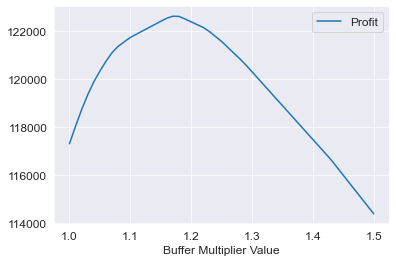

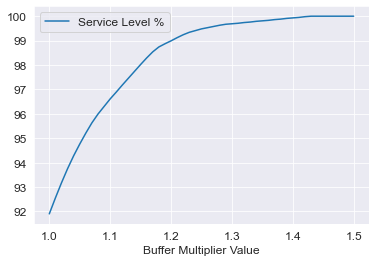

In [82]:
multiplier = list(np.arange(1.0,1.51,0.01))
revenue_list = []
cost_list = []
profit_list = []
service_level_list = []
for x in multiplier:
    human_buffer_multiplier = x
    comparison_df['max_human_buffered_satisfied_units'] = np.minimum(comparison_df['predicted_demand_units']*human_buffer_multiplier, 
                                                             comparison_df['demand_units'])

    revenue = comparison_df['max_human_buffered_satisfied_units'].sum()*unit_sale_price
    cost = (human_buffer_multiplier*comparison_df['predicted_demand_units'].sum()*unit_cost)
    profit = (comparison_df['max_human_buffered_satisfied_units'].sum()*unit_sale_price) - (human_buffer_multiplier*comparison_df['predicted_demand_units'].sum()*unit_cost)
    service_level = comparison_df['max_human_buffered_satisfied_units'].sum()/actual_demand_units
    profit_list.append(profit)
    revenue_list.append(revenue)
    cost_list.append(cost)    
    service_level_list.append(service_level)
    
    
profit_df = pd.DataFrame(data={'Buffer Multiplier Value':multiplier,
                               'Profit':profit_list,
                               'Revenue':revenue_list,
                               'Cost of Goods':cost_list,
                               'Service Level %':service_level_list})

profit_df['Service Level %'] = (100.*profit_df['Service Level %']).round(2)

profit_df.plot(x='Buffer Multiplier Value',y='Profit')
profit_df.plot(x='Buffer Multiplier Value',y='Service Level %')

profit_df

<AxesSubplot:xlabel='Buffer Multiplier Value', ylabel='Service Level %'>

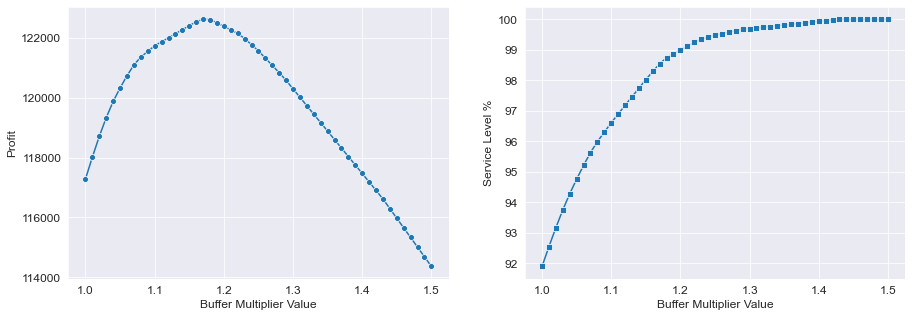

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")
fig, axs = plt.subplots(ncols=2,figsize=(15,5))
sns.lineplot(x='Buffer Multiplier Value', y='Profit',marker="o", data=profit_df, ax=axs[0])
sns.lineplot(x='Buffer Multiplier Value', y='Service Level %',marker="s", data=profit_df, ax=axs[1])


<AxesSubplot:xlabel='Buffer Multiplier Value', ylabel='Cost of Goods'>

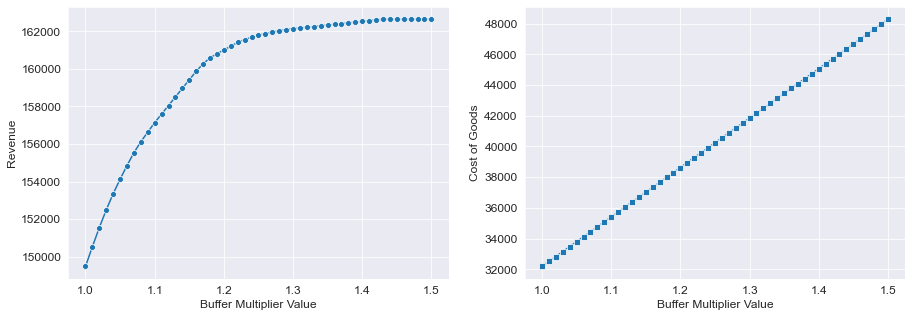

In [84]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(ncols=2,figsize=(15,5))
sns.lineplot(x='Buffer Multiplier Value', y='Revenue',marker="o", data=profit_df, ax=axs[0])
sns.lineplot(x='Buffer Multiplier Value', y='Cost of Goods',marker="s", data=profit_df, ax=axs[1])

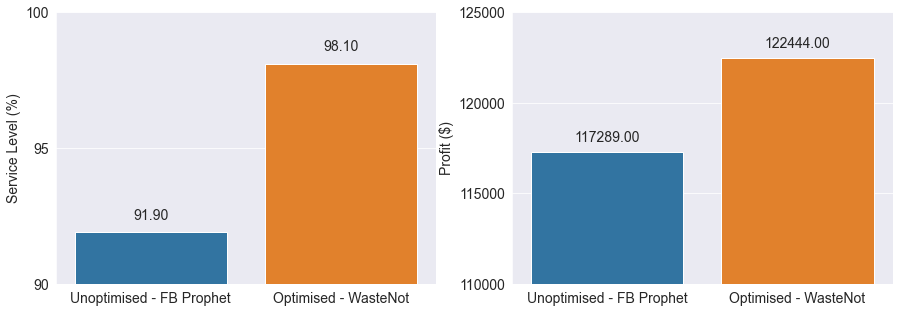

In [85]:
scenario_name = ['Unoptimised - FB Prophet','Optimised - WasteNot']
scenario_service_levels = [100*comparison_df['unbuffered_satisfied_units'].sum()/actual_demand_units, 
                           100.*comparison_df['buffered_satisfied_units'].sum()/actual_demand_units]
scenario_profit = [(comparison_df['unbuffered_satisfied_units'].sum()*unit_sale_price) - (comparison_df['predicted_demand_units'].sum()*unit_cost),
                   (comparison_df['buffered_satisfied_units'].sum()*unit_sale_price) - (comparison_df['optimised_demand_units'].sum()*unit_cost)]

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = 1.005*(p.get_y() + p.get_height())
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center",fontsize=14) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# fig, ax = plt.subplots(1, 2)


plt.rcParams['font.size'] = '14'
sns.set_style("darkgrid")
fig, axs = plt.subplots(ncols=2,figsize=(15,5))

sns.barplot(x=scenario_name, y=scenario_service_levels, ax=axs[0])
axs[0].set(ylim=(90, 100), ylabel='Service Level (%)')
axs[0].yaxis.set_ticks([90,95,100])

sns.barplot(x=scenario_name, y=scenario_profit, ax=axs[1])
axs[1].set(ylim=(110000, 125000), ylabel='Profit ($)')
axs[1].yaxis.set_ticks([110000,115000,120000,125000])
show_values_on_bars(axs)



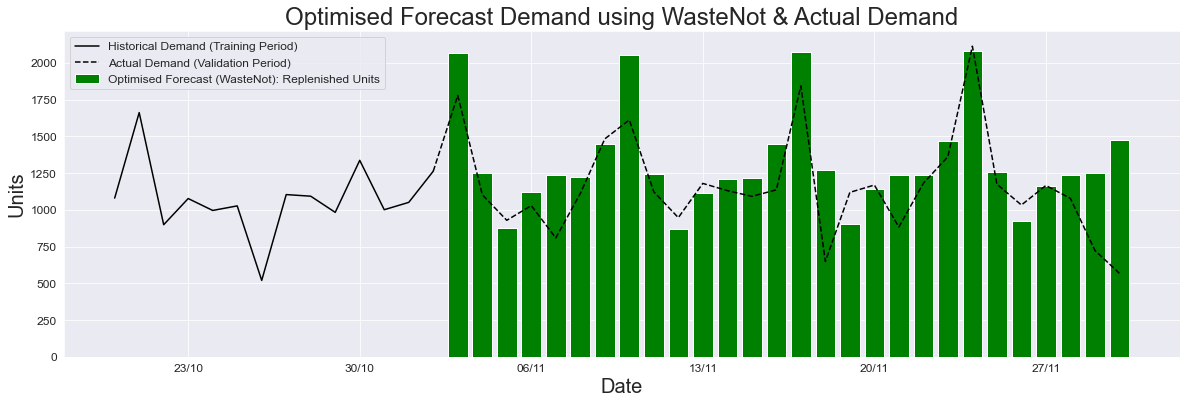

In [86]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

training_cond = ((input_df['timestamp']>='2017-10-20')&
                 (input_df['timestamp']<='2017-11-02'))
test_cond = ((input_df['timestamp']>='2017-11-02')&
             (input_df['timestamp']<='2017-11-30'))

# Specify how our lines should look
ax.plot(input_df.loc[training_cond].timestamp[-60:], input_df.loc[training_cond].demand_units[-60:], color='black', 
        linestyle='-', label='Historical Demand (Training Period)')

ax.plot(input_df.loc[test_cond].timestamp, input_df.loc[test_cond].demand_units, color='black', 
        linestyle='--', label='Actual Demand (Validation Period)')


ax.bar(comparison_df.timestamp, comparison_df.optimised_demand_units, color='green', 
       label='Optimised Forecast (WasteNot): Replenished Units')

# # For a less busy graph, only show the beginning of each week (Monday) as a major label
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_minor_locator(mdates.DayLocator())

ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Units', fontsize=20)
ax.set_title('Optimised Forecast Demand using WasteNot & Actual Demand', fontsize=24)

ax.grid(True)
ax.legend(loc='upper left');

Mean Number of Units: 1161.75


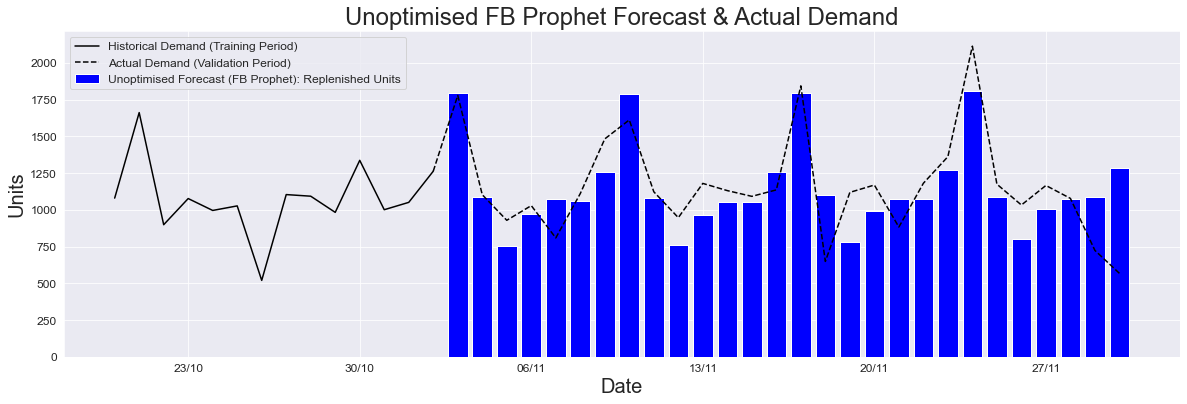

In [87]:
print ('Mean Number of Units:',comparison_df['demand_units'].mean())

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

training_cond = ((input_df['timestamp']>='2017-10-20')&
                 (input_df['timestamp']<='2017-11-02'))
test_cond = ((input_df['timestamp']>='2017-11-02')&
             (input_df['timestamp']<='2017-11-30'))

# Specify how our lines should look
ax.plot(input_df.loc[training_cond].timestamp[-60:], input_df.loc[training_cond].demand_units[-60:], color='black', 
        linestyle='-', label='Historical Demand (Training Period)')

ax.plot(input_df.loc[test_cond].timestamp, input_df.loc[test_cond].demand_units, color='black', 
        linestyle='--', label='Actual Demand (Validation Period)')

ax.bar(comparison_df.timestamp, comparison_df.predicted_demand_units, color='blue', 
       label='Unoptimised Forecast (FB Prophet): Replenished Units')

# # For a less busy graph, only show the beginning of each week (Monday) as a major label
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_minor_locator(mdates.DayLocator())

ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Units', fontsize=20)
ax.set_title('Unoptimised FB Prophet Forecast & Actual Demand', fontsize=24)

ax.grid(True)
ax.legend(loc='upper left');

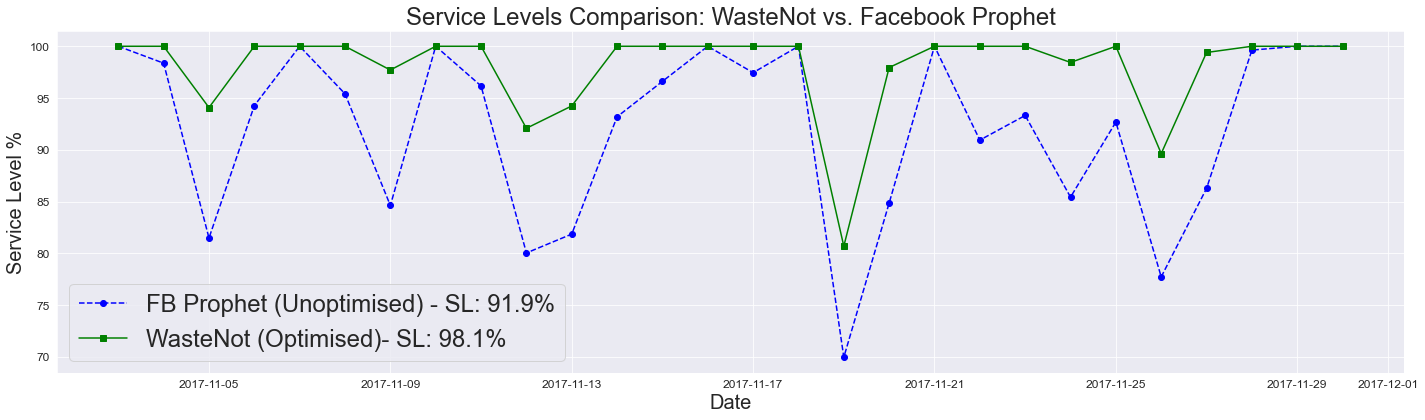

In [88]:
input_df
comparison_df

comparison_df['unbuffered_service_level'] = 100.*comparison_df['unbuffered_satisfied_units']/comparison_df['demand_units']
comparison_df['buffered_service_level'] = 100.*comparison_df['buffered_satisfied_units']/comparison_df['demand_units']

# print (comparison_df['demand_units'].mean())

# plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))
width = 0.35  # the width of the bars

training_cond = ((input_df['timestamp']>='2017-10-20')&
                 (input_df['timestamp']<='2017-11-02'))
test_cond = ((input_df['timestamp']>='2017-11-02')&
             (input_df['timestamp']<='2017-11-30'))

ax.plot(comparison_df.timestamp, comparison_df.unbuffered_service_level, color='blue', 
        marker="o", linestyle='--', 
       label='FB Prophet (Unoptimised) - SL: 91.9%')

ax.plot(comparison_df.timestamp, comparison_df.buffered_service_level, color='green', 
        marker="s", linestyle='-', 
       label='WasteNot (Optimised)- SL: 98.1%')


ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Service Level %', fontsize=20)
ax.set_title('Service Levels Comparison: WasteNot vs. Facebook Prophet', fontsize=24)
fig.tight_layout()
ax.grid(True)
ax.legend(loc='lower left', prop={'size': 24});




1161.75


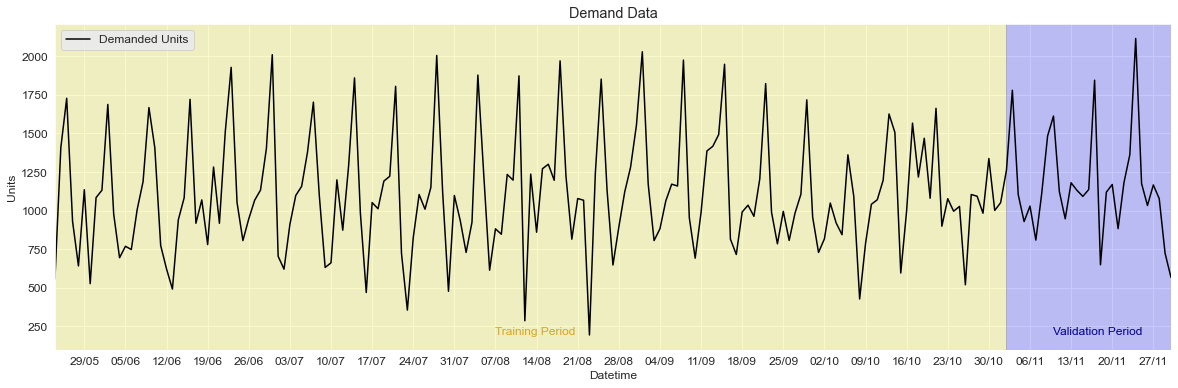

In [89]:
input_df
comparison_df

print (comparison_df['demand_units'].mean())

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

training_cond = (input_df['timestamp']<='2017-11-02')
test_cond = ((input_df['timestamp']>='2017-11-03')&
             (input_df['timestamp']<='2017-11-30'))

# Specify how our lines should look
ax.plot(input_df.timestamp, input_df.demand_units, color='black', 
        linestyle='-', label='Demanded Units')

ax.annotate('Training Period', xy =('2017-08-07', 200),
            xytext =('2017-08-07', 200),
            color='goldenrod') 

ax.annotate('Validation Period', xy =('2017-11-10', 200),
            xytext =('2017-11-10', 200),
            color='darkblue') 
            
ax.axvspan(*mdates.datestr2num(['2017-05-24', '2017-11-02']), color='yellow', alpha=0.2)
ax.axvspan(*mdates.datestr2num(['2017-11-02', '2017-11-30']), color='blue', alpha=0.2)

# # For a less busy graph, only show the beginning of each week (Monday) as a major label
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.set_xlim(['2017-05-24', '2017-11-30'])

ax.set_xlabel('Datetime')
ax.set_ylabel('Units')
ax.set_title('Demand Data')

ax.grid(True)
ax.legend(loc='upper left');